## Setup

In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

## Quick look at the data

In [3]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


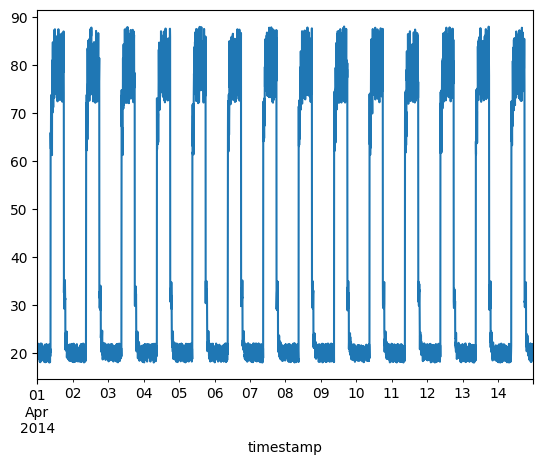

In [4]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

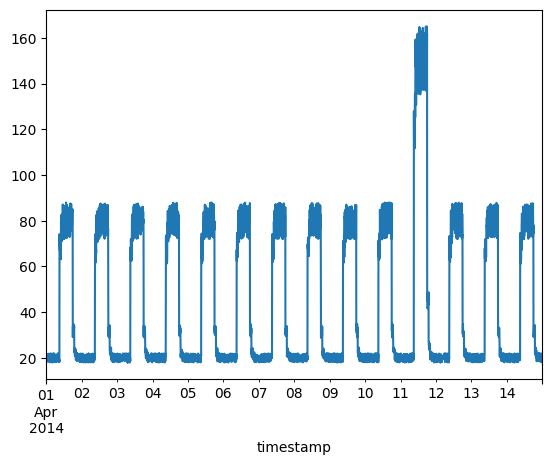

In [5]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

## Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [6]:

# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [46]:
TIME_STEPS = 288


# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    print(len(values))
    for i in range(len(values)-287):
        #print(i, (i + time_steps))
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

x_train[0][1],x_train[1][0]

4032
Training input shape:  (3745, 288, 1)


(array([-0.72899302]), array([-0.72899302]))

In [8]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 144, 32)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 144, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 72, 16)              │           3,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose (Conv1DTranspose)   │ (None, 144, 16)             │           1,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 144, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_1 (Conv1DTranspose) │ (None, 288, 32)             │           3,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_2 (Conv1DTranspose) │ (None, 288, 1)              │             225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [9]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.7415 - val_loss: 0.0726
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0837 - val_loss: 0.0385
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0584 - val_loss: 0.0342
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0497 - val_loss: 0.0298
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0435 - val_loss: 0.0275
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0395 - val_loss: 0.0260
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0361 - val_loss: 0.0244
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0329 - val_loss: 0.0230
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0306 - val_loss: 0.0221
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - loss: 0.0283 - val_loss: 0.0217
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0269 - val_loss: 0.0226
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss:

Let's plot training and validation loss to see how the training went.

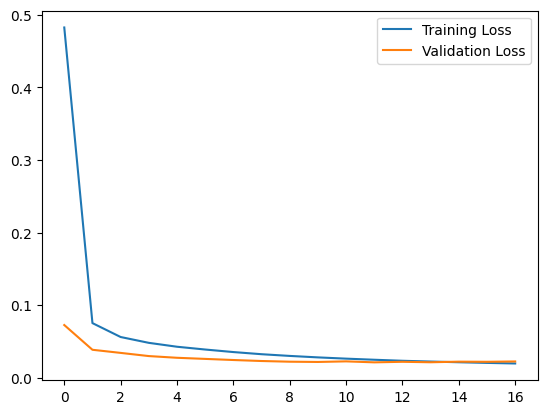

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


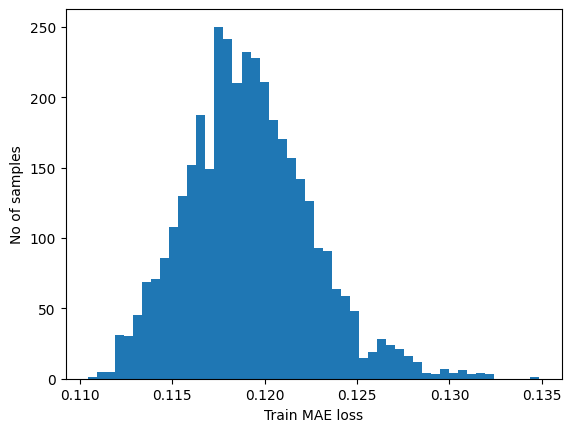

Reconstruction error threshold:  0.13485394895470437


In [11]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

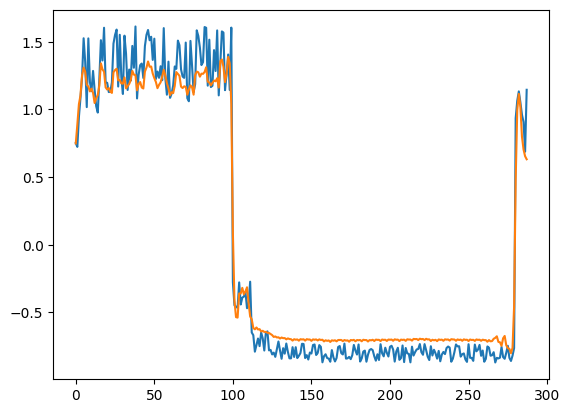

In [58]:
# Checking how the first sequence is learnt
plt.plot(x_train[2708])
plt.plot(x_train_pred[2708])
plt.show()

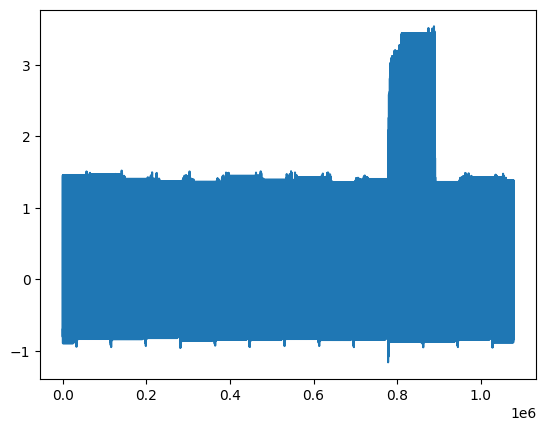

In [59]:
# Checking how the first sequence is learnt
plt.plot(x_test_pred.reshape(-1))
plt.show()

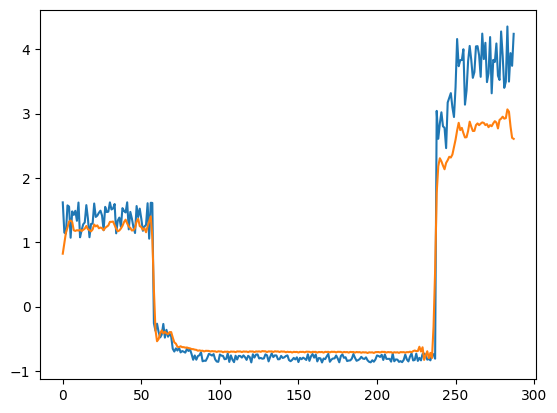

In [61]:
# Anomali burada
plt.plot(x_test[2750])
plt.plot(x_test_pred[2750])
plt.show()

### Prepare test data

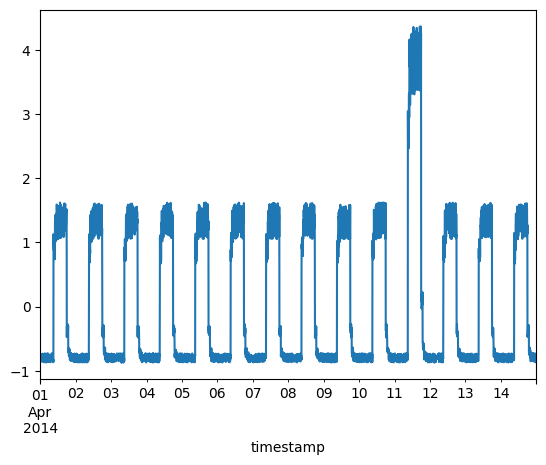

Test input shape:  (3745, 288, 1)
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


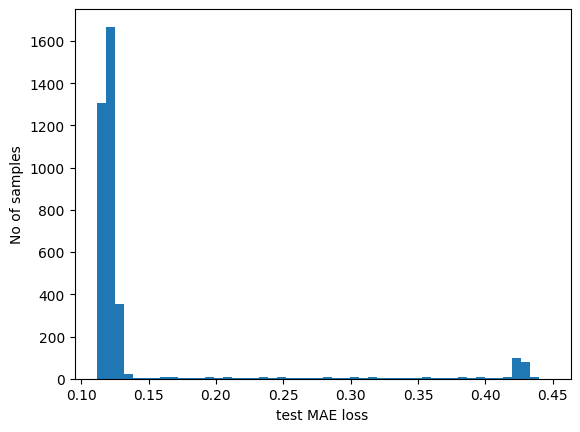

Number of anomaly samples:  399
Indices of anomaly samples:  (array([1650, 1651, 1652, 1654, 2696, 2702, 2703, 2704, 2705, 2706, 2707,
       2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718,
       2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729,
       2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740,
       2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751,
       2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762,
       2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773,
       2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784,
       2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795,
       2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806,
       2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817,
       2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828,
       2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2

In [13]:

df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [21]:
test_mae_loss[0],threshold

(0.11637075709285037, 0.13485394895470437)

In [14]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

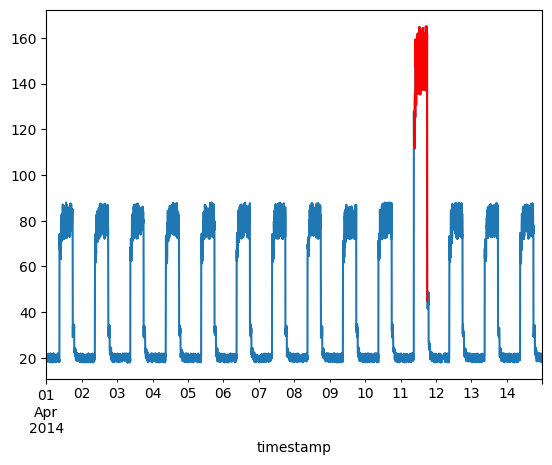

In [23]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()